Notebook that attempts to recreate the ODAM bounding heatmap implementation 

# Imports

In [1]:
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html
!git clone https://github.com/ultralytics/yolov5
!cd yolov5 & pip install -r requirements.txt/

Looking in links: https://download.pytorch.org/whl/lts/1.8/torch_lts.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 608.0 kB/s eta 0:00:000:0100:03
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 14.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 61.0 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.0
    Uninstalling torch-1.13.0:
      Successfully uninstalled torch-1.13.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.0
    Uninstalling torchvision-0.14.0:
      Successfully uninstalled torchvision-0.14.0
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.13.0
    Uninstalling torchaudio-0.13.0:
      Successfully uninstalled torchaudio-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency confli

In [2]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import cv2

# Load Model

In [3]:
yolov5 = torch.hub.load('ultralytics/yolov5', 'yolov5s')

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-4-24 Python-3.7.12 torch-1.8.1+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)



requirements: /root/.cache/torch/hub/requirements.txt not found, check failed.


  0%|          | 0.00/14.1M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [4]:
yolov5

AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

# Trying the model

In [5]:
img = 'https://ultralytics.com/images/zidane.jpg'

In [6]:
img = 'https://cdn.vox-cdn.com/thumbor/W3oQShjd59YE1hy4GEuua2wRU1g=/45x0:2958x2185/1400x1050/filters:focal(45x0:2958x2185):format(jpeg)/cdn.vox-cdn.com/uploads/chorus_image/image/42522848/134002823.0.0.jpg'

In [7]:
results = yolov5(img)
print(results)

image 1/1: 1050x1400 27 cars, 1 bus, 4 trucks
Speed: 1068.0ms pre-process, 25.7ms inference, 2.4ms NMS per image at shape (1, 3, 480, 640)


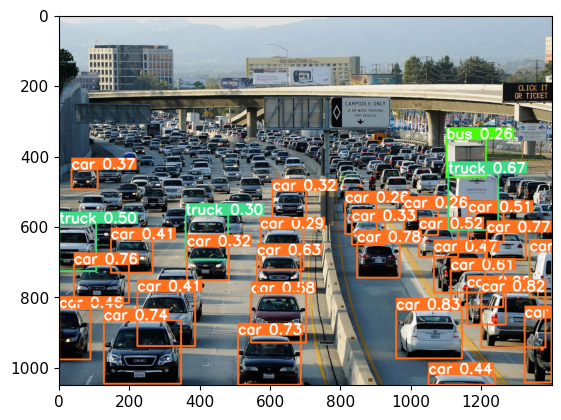

In [8]:
%matplotlib inline 
plt.imshow(np.squeeze(results.render()))
plt.show()

tensor([ 742.97485,   48.39551, 1141.84448,  720.00000], device='cuda:0')


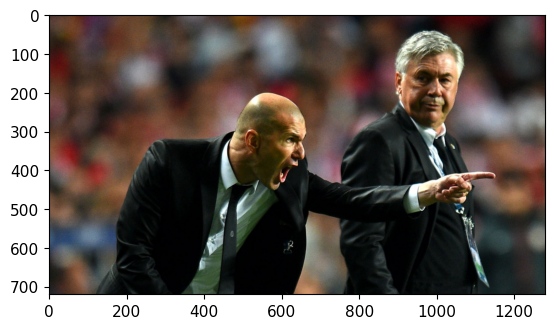

In [14]:
import urllib.request
from PIL import Image

url = 'https://ultralytics.com/images/zidane.jpg'
img_path= "/kaggle/working/zidane.png"
urllib.request.urlretrieve(url, img_path)

img = np.array(Image.open(img_path).convert('RGB'))

# passing the image in the model
plt.imshow(img)
output = yolov5(img)
print(output.xyxy[0][0][:4])
#heatmap = gradCam(category=0.0, model = yolov5, image = img)

In [ ]:
print(output.xywh)
print(output.xywhn)
print(output.xyxy)
print(output.xyxyn)

# ODAM

In [25]:
import cv2

def ODAM(p, model, image):
    gradients = []
    features = []

    def _backward_hook(model, grad_input, grad_output):
        gradients.append(grad_output[0])

    def _forward_hook(model, feature_input, feature_output):
        features.append(feature_output.data)

    # initialize the hooks
    model.model.model.model[23].cv3.act.register_forward_hook(_forward_hook)
    model.model.model.model[23].cv3.act.register_backward_hook(_backward_hook)

    # get the output of the model
    output = model(image)
    class_score = output.xyxy[0][p][4]
    class_bbox = output.xyxy[0][p][:4]

    # creating the signal that will be backpropagated
    signal = torch.zeros_like(class_score)
    signal = signal.requires_grad_(True)
    signal = torch.sum(signal * class_score)

    # back propagate the signal to get the gradients
    model.zero_grad()
    signal.backward()
    
    print(gradients)

    # calculating the importance weight map w(p)
    weight = torch.mean(gradients[0], axis=(2, 3), keepdim=True)

    # local smoothing operation
    kernel_size = calculate_kernel_size(class_bbox, image.shape[2], image.shape[3])
    kernel = gaussian_kernel(kernel_size, kernel_size // 3).to(image.device)
    weight = F.conv2d(weight, kernel, padding=kernel_size // 2)

    # calculating the instance-specific heat map H(p)
    heatmap = F.relu(weight * features[0])

    return heatmap.squeeze()

def calculate_kernel_size(bbox, h, w):
    bbox_h = bbox[3] - bbox[1]
    bbox_w = bbox[2] - bbox[0]
    bbox_ratio = bbox_h / bbox_w
    image_ratio = h / w
    if bbox_ratio >= image_ratio:
        return int(round(bbox_h * h / bbox_w))
    else:
        return int(round(bbox_w * w / bbox_h))

def gaussian_kernel(kernel_size, sigma):
    gauss = torch.Tensor([math.exp(-(x - kernel_size//2)**2/float(2*sigma**2)) for x in range(kernel_size)])
    return gauss/gauss.sum()

import urllib.request
from PIL import Image

url = 'https://ultralytics.com/images/zidane.jpg'
img_path= "/kaggle/working/zidane.png"
urllib.request.urlretrieve(url, img_path)

img = np.array(Image.open(img_path).convert('RGB'))
heatmap = ODAM(0, yolov5, img)

#heatmap = gradCam(category=0.0, model = yolov5, image = img)

[]


IndexError: list index out of range

In [ ]:
model(img)

In [ ]:
model.model.model.model[21].conv

In [ ]:
model.names